# Disclaimer: This tutorial is mostly adapted from Udacity Deep Learning Nanodegree Projects and Pytorch official examples!

In [1]:
# Let's import stuff! 
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import numpy as np
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from torch.optim import lr_scheduler
import numpy as np
import time
import os
import argparse
import copy
import pandas as pd

plt.ion()   # imakes things interactive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [3]:
data_dir = '/content/gdrive/My Drive/brainz/'

In [7]:
data_dir = '/home/meltoscan/brainz'

In [ ]:
# pytorch makes data in a very particular way!
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], # mean of the imagenet 
                             [0.229, 0.224, 0.225]) # standard deviation of the imagenet 
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}
# Using augmentation and normalization for training and validation datasets,
# augmentation for training images, normalization for validation ones.
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

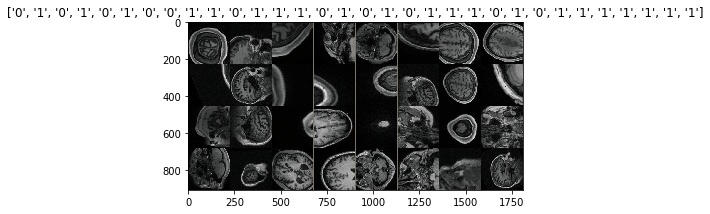

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
class TestDataset(data.Dataset):
    '''
    Custom dataset class for test dataset which contains uncategorized images.
    The category index is set to 0 for all images .
    It also returns the filename of each image.
    '''
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.png'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        img_name = img_path.split('/')[-1]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0, img_name
    
    
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')
    
# Image transformations
data_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


    


# Test dataset
test_dataset = TestDataset(data_dir + 'test', transform=data_transforms)

# Create the dataloaders
batch_size = 32

test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [26]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.figure(figsize=(20,10))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [15]:
model = train_model(model, criterion, optimizer_conv, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2637 Acc: 0.9027
valid Loss: 0.1348 Acc: 0.9771

Epoch 1/24
----------
train Loss: 0.1301 Acc: 0.9616
valid Loss: 0.0879 Acc: 0.9886

Epoch 2/24
----------
train Loss: 0.1125 Acc: 0.9677
valid Loss: 0.1092 Acc: 0.9813

Epoch 3/24
----------
train Loss: 0.1046 Acc: 0.9699
valid Loss: 0.0942 Acc: 0.9813

Epoch 4/24
----------
train Loss: 0.0990 Acc: 0.9684
valid Loss: 0.0788 Acc: 0.9896

Epoch 5/24
----------
train Loss: 0.0873 Acc: 0.9749
valid Loss: 0.0970 Acc: 0.9823

Epoch 6/24
----------
train Loss: 0.0880 Acc: 0.9716
valid Loss: 0.0879 Acc: 0.9849

Epoch 7/24
----------
train Loss: 0.0822 Acc: 0.9742
valid Loss: 0.0792 Acc: 0.9901

Epoch 8/24
----------
train Loss: 0.0792 Acc: 0.9769
valid Loss: 0.0837 Acc: 0.9865

Epoch 9/24
----------
train Loss: 0.0796 Acc: 0.9761
valid Loss: 0.0800 Acc: 0.9886

Epoch 10/24
----------
train Loss: 0.0784 Acc: 0.9764
valid Loss: 0.0727 Acc: 0.9896

Epoch 11/24
----------
train Loss: 0.0869 Acc: 0.9729
valid Loss

<Figure size 432x288 with 0 Axes>

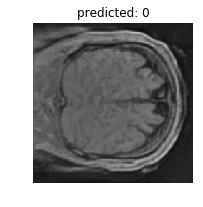

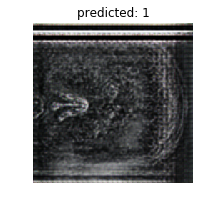

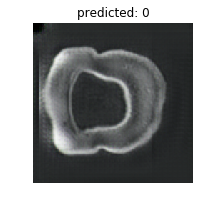

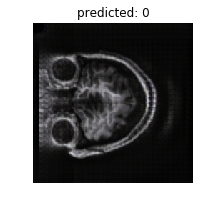

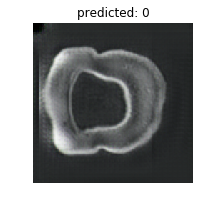

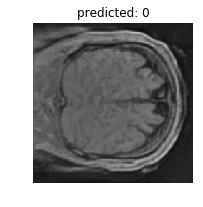

In [27]:
visualize_model(model)

In [ ]:
#due to some issues we do no have test accruacy